# Embeddings to test

* UMAP
* t-SNE
* Parametric UMAP (part of UMAP)
* DenseMap (part of UMAP)
* [PacMap](https://github.com/YingfanWang/PaCMAP)
* [TriMap](https://github.com/eamid/trimap)
* PCA
* Laplacian eigenmaps
* MDS
* Isomap
* [MDE](https://github.com/cvxgrp/pymde)
* [PHATE](https://github.com/KrishnaswamyLab/PHATE)
* ForceAtlas2
* dbMAP
* https://github.com/satwik77/libnmf


# Experiments

* distance/distance-rank preservation with varying ```n_neighbors```, ```n_components``` and ```min_dist```, measured with Pearson's corr.
* hierarchical embedding: original -> 1000d -> 100d -> 2d
* negative test: does it magically create clusters? Test using a high dimensional Gaussian


Metrics:
* Spearman rank correlation between samples
* Pearson correlation of distances
* Distance correlation of distances
* Average Jaccard distance


In [4]:
%load_ext autoreload
%autoreload 1
#%aimport omic_helpers
%matplotlib inline

#from omic_helpers import graph_clustering


from sklearn import datasets
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler, MinMaxScaler, FunctionTransformer
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

import umap
import pacmap
import trimap
import pymde
import ivis
import phate
#import dbmap
#https://github.com/BGU-CS-VIL/DeepDPM

import pandas as pd
import seaborn as sns


from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, KernelPCA, NMF, FactorAnalysis
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness
from tqdm import tqdm
from scipy.sparse import csr_matrix
import gc


sys.path.append('../')
from embedders import embedding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from utils import poincarre_dist

In [6]:
def get_intra_sample_distances(X, how='euclidean'):
    if how == 'euclidean':  
        return distance.pdist(X)

In [7]:
# [x] Sammon mapping: https://arxiv.org/pdf/2009.08136.pdf
# [x] landmark maximum variance unfolding 
# [x] Landmark MDS
# [x] GSOM: https://github.com/CDAC-lab/pygsom/tree/master/gsom -> never mind this is a clustering method..
# [x] SMACOF

# IVIS: https://github.com/beringresearch/ivis, https://www.nature.com/articles/s41598-019-45301-0
# RankVisu
# diffeomorphic dimensionality reduction Diffeomap
# FastMap MDS: https://github.com/shawn-davis/FastMapy
# FactorizedEmbeddings: https://github.com/TrofimovAssya/FactorizedEmbeddings, https://academic.oup.com/bioinformatics/article/36/Supplement_1/i417/5870511
# MetricMap
# SparseMap: https://github.com/vene/sparsemap
# growing curvilinear component analysis
# curvilinear distance analysis
# autoencoder NeuroScale
# PHATE
# GPLVM
# FA
# Nonlinear PCA
# SDNE 
# GCN
# Graph Factorisation
# HOPE
# opt-SNE: https://github.com/omiq-ai/Multicore-opt-SNE
#  Poincare embedding : https://github.com/facebookresearch/poincare-embeddings
# NN-graph/Parametric UMAP -> GraphSage/Node2Vec/etc.. see NetworkX and karateclub!
# https://github.com/benedekrozemberczki/karateclub
# https://github.com/palash1992/GEM-Benchmark, https://github.com/palash1992/GEM

# https://www.sciencedirect.com/science/article/pii/S0950705118301540

# Multi-dimensional datasets

In [8]:
dimensionality = 100
num_blobs = 3
test_data_multidim = []

rnd_perturbation = np.random.normal(0, 1, (1000,dimensionality))
test_data_multidim.append(('blobs1', datasets.make_blobs(n_samples=1000, 
                                                         n_features=dimensionality, 
                                                         centers=num_blobs)[0]+rnd_perturbation))
test_data_multidim.append(('blobs2', datasets.make_blobs(n_samples=1000, 
                                                         n_features=dimensionality, 
                                                         centers=2*num_blobs)[0]+rnd_perturbation))
#test_data_multidim.append(('Class1', datasets.make_classification(n_samples=1000, 
#                                                                  n_features=dimensionality, 
#                                                                  n_informative=20, 
#                                                                  n_redundant=0)[0]+rnd_perturbation))
#test_data_multidim.append(('Class2', datasets.make_classification(n_samples=1000, 
#                                                                  n_features=dimensionality, 
#                                                                  n_informative=5, 
#                                                                  n_redundant=0)[0]+rnd_perturbation))

In [9]:
num_samples = 1000
sample_size = 250
sample_selection = np.random.randint(0,num_samples, sample_size)

In [29]:
embedder_type = 'trimap' # 
n_n = 77
n_landmarks = 100
reduce_dim = 3
scaler = StandardScaler() # QuantileTransformer(output_distribution='normal')#  QuantileTransformer(output_distribution='normal')
dfun = 'manhattan' # poincarre_dist, manhattan/cityblock, minkowski


In [30]:

embedder = {}
if embedder_type == 'umap':
    embedder['umap'] = umap.UMAP(n_components=reduce_dim, densmap=True, metric=dfun,
                             n_neighbors=n_n, min_dist=0., disconnection_distance=15.)
elif embedder_type == 'trimap':
    embedder['trimap'] = trimap.TRIMAP(n_dims=reduce_dim, n_iters=2500);

elif embedder_type == 'pacmap':     
    embedder['pacmap'] = pacmap.PaCMAP(n_dims=reduce_dim, n_neighbors=n_n)

elif embedder_type == 'SpectralEmbedding': 
    embedder['SpectralEmbedding'] = SpectralEmbedding(n_components=reduce_dim, n_neighbors=n_n)

elif embedder_type == 'SpectralEmbedding':     
    embedder['SpectralEmbedding'] = Isomap(n_components=reduce_dim)

elif embedder_type == 'MDS':     
    embedder['MDS'] = MDS(n_components=reduce_dim, metric=dfun)

elif embedder_type =='IVIS':
    embedder['IVIS'] = ivis.Ivis(embedding_dims=reduce_dim, k=n_n)

elif embedder_type == 'PHATE':
    embedder['PHATE'] = phate.PHATE(n_components=reduce_dim, k=n_n, t='auto', mds_solver='smacof')

elif embedder_type == 'KernelPCA':     
    embedder['KernelPCA'] = KernelPCA(n_components=reduce_dim, kernel='sigmoid')
    
elif embedder_type == 'PCA':     
    embedder['PCA'] = PCA(n_components=reduce_dim)
    
elif embedder_type == 'FA':     
    embedder['FA'] = FactorAnalysis(n_components=reduce_dim, max_iter=1000)

elif embedder_type == 'dbmap':
    embedder['dbmap'] = dbmap.diffusion.Diffusor(n_components=120, ann_dist='euclidean')

elif embedder_type == 'LLE':
    embedder['LLE'] = LLE(n_components=reduce_dim, n_neighbors=n_n, method='ltsa')

elif embedder_type == 'NMF':
    embedder['NMF'] = NMF(n_components=reduce_dim, max_iter=10000)

elif embedder_type == 'TSNE':
    embedder['TSNE'] = TSNE(n_components=3, perplexity=50)

elif embedder_type == 'Sammon':
    embedder['Sammon'] = embedding.Sammon(n_components=reduce_dim, n_neighbors=n_n,
                                             max_iterations=250, learning_rate=0.05, init_type='PCA')

elif embedder_type == 'MVU':
    embedder['MVU'] = embedding.MaximumVarianceUnfolding(n_components=2, n_neighbors=n_n)

elif embedder_type == 'LMVU':
    embedder['LMVU'] = embedding.LandmarkMaximumVarianceUnfolding(n_components=reduce_dim, 
                                                                     n_neighbors=n_n, 
                                                                     n_landmarks=n_landmarks)

elif embedder_type == 'LMDS':
    embedder['LMDS'] = embedding.LandmarkMultiDimensionalScaling(n_components=reduce_dim,
                                                                 n_landmarks=n_landmarks,
                                                                 metric=dfun)

In [31]:
#embedder['MVU']
#embedder['GSOM']
#embedder['MetricMap']
#embedder['SparseMap']

test_sets_embedded = []
if embedder_type == 'dbmap':
    pipe = Pipeline([('scaler', scaler), 
                     ('prepmap', embedder['dbmap']), 
                     ('reducer', embedder['umap'])])
    for _, ts in tqdm(test_data_multidim):
        tts = embedder['dbmap'].fit_transform(ts)
        test_sets_embedded.append(np.array(pipe.fit_transform(tts)))
elif embedder_type == 'NMF':    
    for _, ts in tqdm(test_data_multidim):
        nonnegger = lambda x: x + 2*np.abs(np.min(x, axis=0))
        nonnegger_F = FunctionTransformer(func=nonnegger)

        pipe = Pipeline([('scaler', scaler), 
                         ('nngr', nonnegger_F), 
                         ('reducer', embedder['NMF'])])
        test_sets_embedded.append(pipe.fit_transform(ts)) 
elif embedder_type == 'LMDS':
    pipe = Pipeline([('scaler', scaler), 
                     ('reducer', embedder[embedder_type])])
    for _, ts in tqdm(test_data_multidim):        
        test_sets_embedded.append(embedder[embedder_type].fit_transform(scaler.fit_transform(ts)))
else:
    pipe = Pipeline([('scaler', scaler), 
                     ('reducer', embedder[embedder_type])])
    for _, ts in tqdm(test_data_multidim):        
        test_sets_embedded.append(pipe.fit_transform(ts))    

100%|██████████| 2/2 [00:17<00:00,  8.68s/it]


In [32]:
#fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(22,25))
#for k, ds in enumerate(test_sets_embedded):
#    j=k%2 
#    i=int(k/2)
#    ax[i,j].scatter(x=ds[:,0], y=ds[:,1], color='black')
#    ax[i,j].set_title(f'Image:{k}')

In [33]:
dist_preservation_overall = []
dists = []
for num in tqdm(range(0,2)):
    dist_or = get_intra_sample_distances(test_data_multidim[num][1][sample_selection,:])
    dist_emb = get_intra_sample_distances(test_sets_embedded[num][sample_selection,:])

    dists.append({'d_or': dist_or, 'd_emb': dist_emb})
    dist_preservation_overall.append({'dataset': test_data_multidim[num][0], 
                              'corr':dcor.distance_correlation(dist_or, dist_emb)})

100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


Text(0.5, 0.98, 'Embedder trimap')

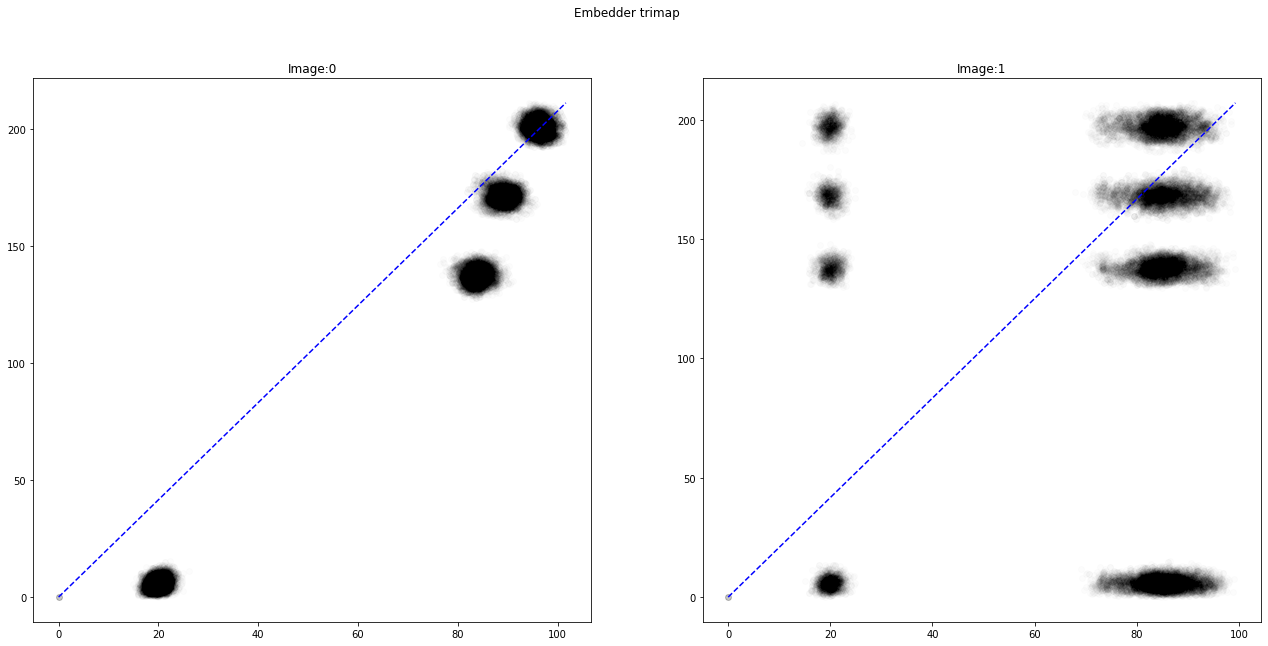

In [34]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,10))
for k, ds in enumerate(dists):
    j=k%2
    ax[j].scatter(x=ds['d_or'], y=ds['d_emb'], color='black', alpha=0.01)
    mx,my = max(ds['d_or']), max(ds['d_emb'])
    ax[j].plot([0,mx], [0, my], ls='--', c='blue')
    ax[j].set_title(f'Image:{k}')
plt.suptitle(f'Embedder {embedder_type}')

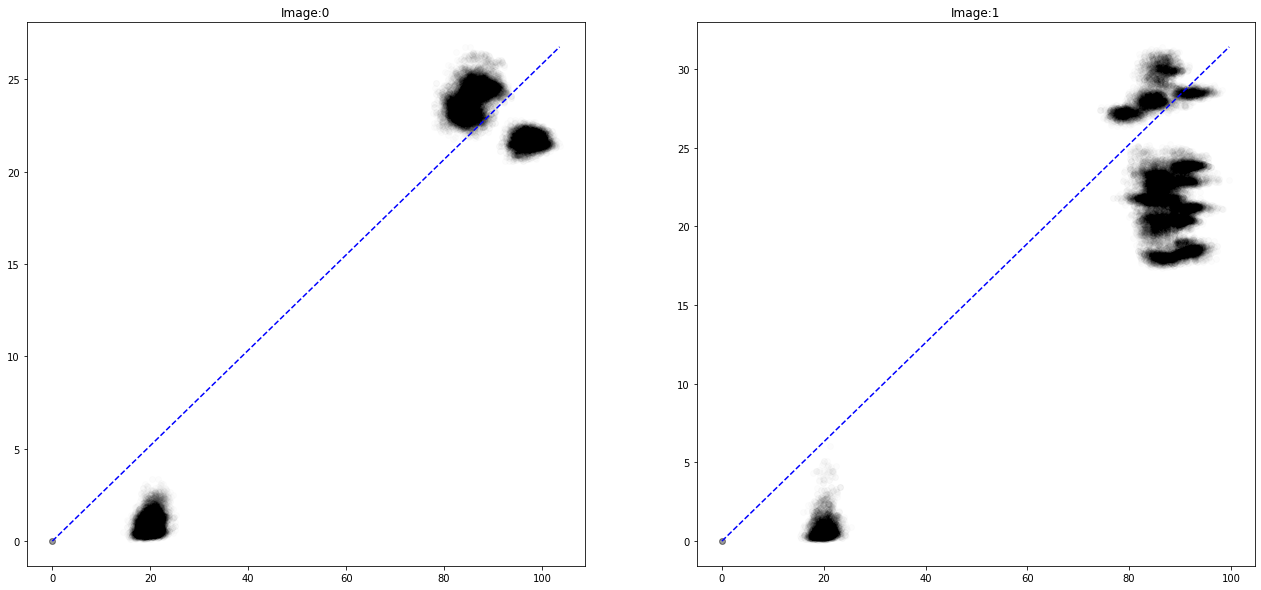

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,10))
for k, ds in enumerate(dists):
    j=k%2
    ax[j].scatter(x=ds['d_or'], y=ds['d_emb'], color='black', alpha=0.01)
    mx,my = max(ds['d_or']), max(ds['d_emb'])
    ax[j].plot([0,mx], [0, my], ls='--', c='blue')
    ax[j].set_title(f'Image:{k}')

In [18]:
dist_preservation_overall

[{'dataset': 'blobs1', 'corr': 0.9966180351761253},
 {'dataset': 'blobs2', 'corr': 0.8925800582660818}]

So far, roughly: *a better metric approximation is co-related with a worse cluster separation*, it seems that you cannot have the cake and eat it.

# Semi-supervised UMAP

The main flavor is to add labels for the different clusters we know we want to 
see. This can be based on a clustering on a sample set of the original data (perhaps also a selection of features).

# Parametric UMAP

* Create nearest-neighbor graph with fuzzy simplicials
* Apply graph embedder

# Anchored embedding

# Distance preserving embedding

* Siamese twins networks
* distance as outcome
* pairs as input

The method IVIS seems to use this idea.

# Ranking based embedder

# Multi-patch UMAP

The core assumption of UMAP is that all points lie on the same manifold. What if we split our data in dense patches prior to the creation of the fuzzy simplicials? 

To make this tractable this split should be computationally in-expensive. One way to go about is to treat overlapping regions with a sufficient number of samples as patches. The embeddings associated with these patches can later be combined.



# Multi-sample UMAP


* $N$ sampled UMAP embedders with/without minimal perturbations
* aligned using Procrustes
* uniform scaling
* concensus distance determination

# Landmarkbased embeddings coupled to sparse exemplar finders

Instead of random landmarks we can use exemplars based on 
* points closest to centroids
* exemplars based on e.g. affinity propagation